In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306087  [    0/60000]
loss: 2.291713  [ 6400/60000]
loss: 2.302733  [12800/60000]
loss: 2.284342  [19200/60000]
loss: 2.297965  [25600/60000]
loss: 2.290226  [32000/60000]
loss: 2.275367  [38400/60000]
loss: 2.274500  [44800/60000]
loss: 2.270294  [51200/60000]
loss: 2.265501  [57600/60000]
Test Error: 
 Accuracy: 42.7%, Avg loss: 2.262042 

Epoch 2
-------------------------------
loss: 2.265741  [    0/60000]
loss: 2.251467  [ 6400/60000]
loss: 2.265357  [12800/60000]
loss: 2.231714  [19200/60000]
loss: 2.253924  [25600/60000]
loss: 2.248237  [32000/60000]
loss: 2.225301  [38400/60000]
loss: 2.236374  [44800/60000]
loss: 2.219495  [51200/60000]
loss: 2.209210  [57600/60000]
Test Error: 
 Accuracy: 57.4%, Avg loss: 2.207191 

Epoch 3
-------------------------------
loss: 2.211051  [    0/60000]
loss: 2.193541  [ 6400/60000]
loss: 2.211651  [12800/60000]
loss: 2.155559  [19200/60000]
loss: 2.187371  [25600/60000]
loss: 2.182715  [32000/600

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [11]:
# Run through model and predict

classes = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
]

model.eval()
x, y = test_data[12][0], test_data[12][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "9", Actual: "9"


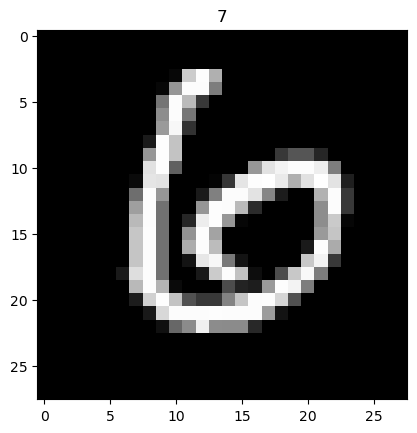

In [12]:
# Show test data samples

import matplotlib.pyplot as plt
plt.imshow(test_data.data[11], cmap='gray')
plt.title('%i' % test_data.targets[0])
plt.show()

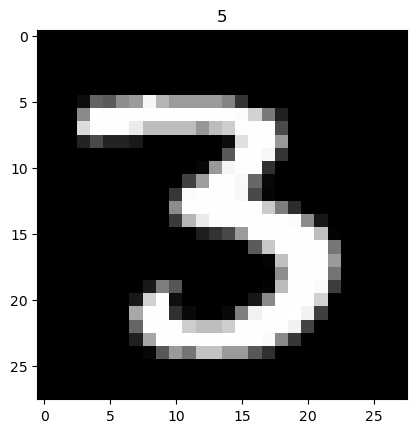

In [13]:
# Show training data samples

import matplotlib.pyplot as plt
plt.imshow(training_data.data[12], cmap='gray')
plt.title('%i' % training_data.targets[0])
plt.show()

In [14]:
# Demo with base64 png encoded image

import cv2
import numpy as np
import base64

# Recieve base64 data
myData = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAeaUlEQVR4Xu2dB3AXxRfHHxh6i1QVYghSBERBQVFQwIiAilExZFQ0tjGKYkHH3mb+FpptFMFxlDKKSFOQZgMExAIKFjQIShEERBGEBBNQ/35PohFS7u63u3e3930zGZhh9+3u522+3O3tvq0gIn/+9UMjARIgAeUEKlBglDOlQxIggf0EKDCcCiRAAtoIUGC0oaVjEiABCgznAAmQgDYCFBhtaOmYBEiAAsM5QAIkoI0ABUYbWjomARKgwHAOkAAJaCNAgdGGlo5JgAQoMJwDJEAC2ghQYLShpWMSIAEKDOcACZCANgIUGG1o6ZgESIACwzlAAiSgjQAFRhtaOiYBEqDAcA6QAAloI0CB0YaWjkmABCgwnAMkQALaCFBgtKGlYxIgAQoM5wAJkIA2AhQYbWjpmARIgALDOUACJKCNAAVGG1o6JgESoMBwDpAACWgjQIHRhpaOSYAEKDCcAyRAAtoIUGC0oaVjEiABCgznAAmQgDYCFBhtaOmYBEiAAsM5QAIkoI0ABUYbWjomARKgwHAOkAAJaCNAgdGGlo5JgAQoMJwDJEAC2ghQYLShpWMSIAEKDOcACZCANgIUGG1o6ZgESIACwzlAAiSgjQAFRhtaOiYBEqDAcA6QAAloI0CB0YaWjkmABCgwnAMkQALaCFBgtKGlYxIgAQoM5wAJkIA2AhQYbWjpmARIgALDOUACJKCNAAVGG1o6JgESoMBwDpAACWgjQIHRhjYcjps2bSqpqamCP/GTlZUlKSkpUqNGDalQAeFXa3/++afk5eXJ8uXL5YUXXpB169bJe++9p7YReosMAQpMZEJVfke7desmDzzwgHTs2FFq1apVfgWDJSA8u3btkmnTpskNN9zgiBDNfgIUmIjGGE8jEJT27dtL9+7dnT+jZIsXL5a+ffvKjh07otRt9tUjAQqMR2BBFS96OunUqZPUrFkzqG4obRdPNUuWLJFzzjmHQqOUbHicUWDCE4t/ehL1pxOvSCE0L730kmRnZwv+TrOHAAUmBLGsW7eujBkzxnnVwdqJjsXXEAyz3C5s377dedX7/vvvyy3LAtEgQIEJKE4QlX79+sldd90laWlpAfUinM3iq1OvXr2koKAgnB1kr1wToMC4RpV4wSJRyczMlB49ekhSUlLiTi31gFelCRMmyIABAywdYTyGRYHRHOdq1arJK6+8Iunp6dYszmpG9h/369evl9atW8uePXtMNsu2FBGgwCgCWdxN8+bNpU+fPpKTkyNt2rSJ7ZqKKrSFhYXO3p4vvvhClUv6MUSAAqMANF59nn/+eTn99NOldu3aUrFiRQVe6eJAAq+//rqcf/75BBMhAhSYBIK1bds2qVevHp9QEmDoterWrVudRXG+MnklF0x5CowP7itWrJDjjjvOR01WUUFg7969csIJJ/CVSQVMzT4oMB4AY48KtrbzFcgDNI1Fx40bJ5dffrnGFug6UQIUGA8E9+3bJ4cccoiHGiyqm8Dq1aulZcuWupuhf58EKDAuwX3++efSrl07l6VZzCSBDRs2OCkpaOEjQIFxEZOGDRsKFhdp4SWA/TI4w0ULFwEKjIt4bNmyRRo1auSiJIsESeCHH36Qxo0bB9kFtn0AAQqMiynxxx9/8FO0C05hKLJy5Uo55phjwtAV9uEvAhQYF9OAKQRcQApRkYcffljuvffeEPUovl2hwLiIvQ0C89tvvzn7RmbPnu3kyS3+4wKBqyJIN4GjEdddd13gTxHJycmyc+dOV/1mIX0EKDAu2EZNYD777DNZsGCBYEMg/oSYmDb8gk+ePNk55BlEfpuZM2c6KTlpwRKgwLjgH3aBQQJt5LgdMmSIIyhhMpzTeu211+S0004z2i3EDDcn8EiBUewHNUaBccE/TIu82I8zf/78QJ9OXCA7qEiTJk0ET1YQHFM2Y8YMycjIMNUc2ymBAAXGxbTA8YA6deq4KKm+CFIVLFu2TO677z6ZN2+e+gYMe5w+fbqce+65xlqtXr06n2KM0T64IQqMS/imXpNwHAFPKFi/mDp1qiBPrW2GHdFLly6VKlWqaB/apEmTnMvmaMEQoMC45P7ll19K27ZtXZb2XgxnaoYPH26tqBxIBJn+sPiMXdI6LT8/31mLoQVDgALjgfvvv/+u9CT17t27BesEgwYNsvJJxQ1a3PSoO4nUsccey9QOboKhoQwFxgNUXHiGvRV+0zXgf+wnn3xSZs2aJWvWrPHQst1F8cr0ySefSKVKlbQM9P3335euXbtq8U2nZROgwPiYIbm5udKqVStXNfHUg6eUSy+9lPcxl0EMr0wbN27U9pWpatWqvAbF1YxVW4gC45Mn3uu/+eYbOfzwww/aSIYF4R9//NHZ1WrjIq1PZK6qgVuDBg1clfVSaOzYsXLFFVd4qcKyCghQYBRApAt1BPAkg4VZ1YZXW+wuppklQIExy5utuSCAXcldunRxUdJ9ETxV4qI7bJqkmSNAgTHHmi25JIBNjdjcqNo6dOjg7ICmmSNAgTHHmi15IIAvP6eccoqHGuUXfeedd6Rnz57lF2QJZQQoMMpQ0pFKAvh0jXNXKu3XX38N7MiHynFEyRcFJkrRillfCwoKpHLlyspGjfUX3gqhDKcrRxQYV5hYKAgCH3zwgXTu3Flp00HkplE6gIg5o8BELGBx6u7xxx/v7PBVaRQYlTTL90WBKZ8RSwREAEcysBNapVFgVNIs3xcFpnxGLBEgAdVpMrDzGtfQ0MwQoMCY4cxWfBJQLTB9+vSRuXPn+uwNq3klQIHxSozljRJQnSIDu4RPPfVUo2OIc2MUmDhHPwJjx96VWrVqKevprl27pHbt2sr80VHZBCgwnCGhJvDRRx/JiSeeqKyP3AujDKUrRxQYV5hYKCgCvXv3ljlz5ihtnl+SlOIs0xkFxhxrtuSDwGGHHSabN2/2UbP0KhQYpTgpMOZwsiUdBFR/SaLA6IhSyT75BGOONVvySYAC4xNcCKpRYEIQBHahbAIUmOjOEApMdGMXm55TYKIbagpMdGMXm55TYKIbagpMdGMXm55TYKIbagpMdGMXm55TYKIbagpMdGMXm55TYKIbagpMdGMXm55TYKIbagpMdGMXi54z6VS0w0yBiXb8rO99+/btZfny5UrHyZ28SnGW6YwCY441W/JBYOHChcrzt1BgfATCZxUKjE9wrGaGwL59+5ReNYIEVrhClmaGAAXGDGe24oOAjqcXXr7mIxAJVKHAJACPVfUR2LBhg6SkpChvgNfHKkfKNRizSNlaogR0iQv61aFDB1mxYkWiXWR9lwT4BOMSFIuZIYAnjPT0dG2N4epYpM2kmSFAgTHDma24IKBbXJjw20UQFBehwCgGSnf+COh8LSrq0YwZMyQjI8NfB1nLFwEKjC9srKSSgAlxQX95q6PKqLnzRYFxx4mlNBGYP3++dO/eXZP3f90WFhZKlSpVtLfDBv5LgALDGREIgTp16gjuPGrVqpWR9vl52gjmgxqhwATDPbatQlhuueUWuffee5Xu0C0LKL4a1axZU/bs2RNb7kENnAITFPmYtQthwVPE8ccfLzghbdIee+wxue2220w2ybb2E6DAcCpoJYCDhRMmTJCsrCwJ4pAhPk3n5uZKu3btnDWYoj7gTFJeXp4sXbpU+vfvL9u3b9fKIa7OKTBxjbyBcTdp0sTZNVuvXj0DrSXWxJo1a2TYsGEydepUik1iKP9TmwKjECZd/U2gevXq8tZbb0mXLl0iiQRrNbNnz5bs7GznKYfmnwAFxj871jyAQGpqqrz88suRFZaSAjpr1iwZMGCA7Nixg/H2QYAC4wMaq/xNoHLlytKpUycZPny4s3hr6z4T5AResmSJnHPOORQaj5OfAuMRWNyL161bV8aNGyc9evSQGjVqxAoHhObxxx/nFykPUafAeIAV16JYU5kyZYr07NmT2eD+mgSrV692Ngiqvu3AxvlFgbExqorGhKeVZcuWSVpamiKP9rjZuHGjloRY9hD6eyQUGNsiqmg8WNTE5jha6QTmzZunNXeNDewpMDZEUeEY8EuD9RWaOwLPPPOMDBo0yF3hGJaiwMQw6KUNuaCgwPkyRPNGAK+R+JpGO5gABYazwiFAcUlsIqxfv16aNm2amBMLa1NgLAyq1yHxtcgrsZLLf/XVV9K2bVs1zizxQoGxJJCJDIOfWxOh99+6o0aNkoEDB6pzGHFPFJiIBzDR7q9du5aP9olCLFYfYn3EEUfIli1bFHqNrisKTHRjp6Tne/fu5eY5JST/dcKNeP+yoMAonlxRc8fXIz0Ru+uuu2TIkCF6nEfIKwUmQsHS0VUKjA6q4lzuduyxx8rKlSv1NBARrxSYiARKVzcpMLrIivz2229Osq38/Hx9jYTcMwUm5AHS3T0KjF7CmzZtEmT2i6tRYOIa+f3jtn2RFwKKJ4jly5fLxIkTnS9mF1xwgTRr1sxY5MeMGSNXXnmlsfbC1BAFJkzRCKAvYf1MjdcL/O8/c+ZMJ8kTfpDfF4Y/E80wB6GZNGmSkS3+EDkcHEUC8rgZBSZuES9hvEG+JmGLPQQDPwsWLFAiHl5Cmpyc7FwA17JlSy/VPJdFjuJevXp5rhf1ChSYqEdQQf9NHRWAkO3evVsWLlwoI0aMMC4mZaEaPXq05OTkKKBZsguMHU9NuIc7TkaBiVO0yxirrsOO3377rTz11FMyZ84cwdUgYbaPP/5Y6yvT9OnT5bzzzgszAuV9o8AoRxpdh7iuo2rVqgkNAPs/du7c6aTYvOmmmyJ3XetPP/2k9R6nvn37OutKcTEKTFwi7XKcfl6XNm/eLNdcc40sXrw44cVXl93UVgz5h7du3ercZa3DsHiNZOkQ4jgYBSYOUfYxRly32qJFi1LvkS4sLHReey6++GLrNpIh5QIWnZOSknyQK79KnF6VKDDlzweWiCGBO++8Ux599FEtI8eCL+6Qwh4k240CY3uEOT5fBCpUqCCrVq1ynuJ0GNaoMjMzdbgOlU8KTKjCwc6EiUCjRo205XXBWky1atXCNFwtfaHAaMFKp7YQmDt3rrYNcn369BH4t9koMDZHl2NLmEDFihWdz+46virFYbGXApPwFKQD2wn07t3b+WKm2rDYm5KS4py5stUoMLZGluNSSuD111+XjIwMpT7h7JNPPpGOHTsq9xsWhxSYsESC/Qg1gSOPPFLWrVsn+Lqk2rC5D7uobTQKjI1R5Zi0ENB1VglpI7KysrT0OWinFJigI8D2I0OgYcOGzmdr1U8xOGFeq1atyHDw0lEKjBdaLBt7AosWLZKuXbsq54BDpjjRbptRYGyLKMejlUDjxo2dnC74fK3SevTo4STcss0oMLZFlOPRTkDHF6WhQ4cKzj/ZZhQY2yLK8WgnoGNfDFJe4MpZ24wCY1tEOR4jBJCuolKlSkrbSktLcz6F22QUGJuiybEYI/DBBx9I586dlbY3fvx4yc7OVuozaGcUmKAjwPYjSaB58+aCS+5VGq41qV27tkqXgfuiwAQeAnYgqgSQWhN7Y1QZziap/jqlqm9+/VBg/JJjvdgTGDJkiNxxxx1KORx++OHactAo7ahLZxQYl6BYjAQOJNC9e3eZP3++UjC25YihwCidHnQWJwLIq4vMdCrNthwxFBiVs4O+YkdAxV1SxaHl5eVpSW4VVGAoMEGRZ7tWEMBdUF26dFE6FtWHKZV2zqMzCoxHYCxOAsUJ6NjVa9NCLwWGvy8kkACBww47TLDNX6X169dPpk2bptJlYL4oMIGhZ8O2EMD+FZWGXcKnnHKKSpeB+aLABIaeDdtCAAuzSHupyvLz8537q20wCowNUeQYAiWAvTDYE6PK8ER0yCGHiOonI1X98+KHAuOFFsuSQAkEdCz0HnroobJjx47I86bARD6EHEDQBHQs9J588sny4YcfBj20hNunwCSMkA5IQJS/zlx33XUyevToyKOlwEQ+hBxAGAioXuhdtmyZdOrUKQxDS6gPFJiE8LEyCfxNQHUCKltyw1Bg+BtCAgoIXHvttTJq1CgFnv52YUtuGAqMsilBR3EmgPSZeIpRaTacSaLAqJwR9BVbAsnJyfLLL78oHT8FRilOOiOBaBNQvTGOAhPt+cDek4BSAhSYg3HyFUnRFMPW7tdee02Q8jApKalEr3/88Yfznq7jbmNFw6CbBAhQYCgwCUyf0qv+73//k3vuuUe8PNLi+tHzzz9fS3/oNBgCFBgKjPKZt3btWmnatKkvvzhrgjMnNDsIUGAoMMpmMr4aINFQ1apVE/K5c+dOgS9a9AlQYCgwCc9iiMGcOXOUXhvK16WEwxIKBxQYCkxCE3H48OFy2223JeSjtMpe1m+0dIBOEyZAgaHA+JpE+OXHPcRHHXWUr/puKtmUJtHNeG0sQ4GhwPia1xs2bJCUlBRfdd1WwgVe1apVc1uc5UJIgAJDgfE8LefNmyc9evTwXM9PBb4m+aEWnjoUGAqMp9n40UcfyYknnuipTiKFKTCJ0Au+LgWGAuN6Fv7www+CC7BMGgXGJG21bSF22Kmt0myYDzwqcMCMwDrId999J8izatpsmFCmmYWlPR15eW2YDxSYA2bo3LlzpVevXsbnLRd5jSNX2iCuLcH1JSqNAqOSZgh8ZWZmyqRJkwLpCT9TB4JdWaPMaFcySj7B7OeCqzoXLFgglSpVUjbpvDiy4X8rL+O1rSxuAMjJyVE2LObkVYYyeEdNmjSRr776SmrVqhVIZ3hUIBDsShvFHUYnnXSSMp/wh7uRom6xf4LBYcUff/wxMHHhYceo/wqJVKxYUX799Vel90lfdNFFMnHixMjDibXA4LVk+/btgZ1mprhE/vfHGcDRRx8tX3/9tdLBtG7dWnJzc5X6DMJZrAXm/fffF6y9BGF8LQqCup42b731VhkxYoQy57jErXbt2sr31SjroAdHsRWYp59+Wm644QYPqNQUxe5gXHFBs4NA9erVBQuyeE1SZTbNkVgKjGlxwRbyJ598UgYPHqxqDtJPSAhs2rRJjjjiCKW9ee655wSfvW2w2AnMkiVLjK3OQ1hmz54tAwYMEKTHpNlFYOTIkTJw4EDlg7Ll4nuAiZXA4AhAWlqa8glRksNVq1Y5r0IUFiO4jTfSoEED2bp1q6dE7247idP72JNlg8VGYFauXClt2rQxEjM8JXXp0sVIW2wkGALvvPOOpKena2kch2y3bNmixbdpp7EQmNtvv12GDh1qhC2uD61bt66RtthIMASqVKki+NKDu7BUmy2X3hdxsV5gsNdl7969WibDgZMLXxMaNmwoOLhIs5fAzTffLE888YSWAf78889Sv359Lb6DcGq9wDz++ONyyy23aGeLnZxt27aVjRs3am+LDQRHAE8viHXlypW1dOL+++8XXORni1kvMHiXbdSokdZ44QkJx/Wx9kKzmwA2SGZkZGgZJBJW6Xjt0tJZl06tFxgETfdJ5UsuuUQmTJjgEjmLRZUADsUiAbyu+YSnbewKtsmsFhgdWcYODP7bb78tZ555pk1zgmMphcCbb76pLdbr16/3fQVxmANmtcD07t3buYVRl23bts15/VKd7FlXf+nXPwGsvWARX0e+oMLCQueO8vz8fP8dDGlNqwVG560ASAreuHHjkIaV3VJNQOeXI3wcQD4iG81qgcFqv44kUjYdRrNxUqsek86nl0WLFslpp52musuh8We1wPz+++9KT7kiajYdRAvNLAx5R3TtAserEdIyFBQUhJyA/+5ZLTCq10ZmzJih7ROl/xCypk4Czz77rODwoQ7D/iycsrfZKDAeomvTGREPw45tUZ1pPfbt2yc1a9a0+ukFE4cC4+HXR9f+Bw9dYFFDBHTfSY40Hmeffbah0QTXDAXGA3sKjAdYES76/fffCzbV6TQkm7d57aWIHQXGwyyiwHiAFdGiJsQlTvmYKTAefhGQf3XPnj0earBolAjofi0CCzy11KlTJxZPL1yD8Tj7x48fL9nZ2R5rsXgUCOhc0C0+/jh8OSo+Xj7BeJj9uKBN98lsD91hUUUEdO74Lt7FuHw5ioXA4Ng7AqrauA6jmmhw/pCfecWKFc5mNxOGPLvItxsns/YJBkKAnbyqBcHWU69xmvQYK/Y0ITG7jqMkJbHEpk+kUo1bEnhrBQZB/umnn6RevXrKf3eQEyQ1NVW5Xzo0Q6B9+/Yyf/58o1cGIyf0nXfeaWaAIWrFaoHRmX0MqTFTUlJCFEp2xQ2Bc889V6ZMmaIl7UJp7a9evVpatmzppnvWlbFaYJA3VedmprVr10qzZs2smxQ2Dig5OVmQHKxjx45Gh7d9+3YtT9FGB5FAY1YLDLjoTpmJCYRdn9wfk8As1Fz1mGOOkY8//liqVaumuaX/uv/ss8/khBNOcNYC42rWCwwEANnCdBqSfnft2tWZxLTwEEAeF9yJ9eCDDypP21HeKJ955hkZNGhQecWs/3frBWbSpEmSmZlpJJAQGOTn3blzp5H22EjpBCD4L774orRo0cI4ptGjR2tL8WB8MAk2aL3AmHhNKh4D7L15+OGHnYu5KDQJzk4f1SEos2bNCkRY0N2FCxdKt27dfPTcziqxEJhx48bJZZddZjSCeO/Gxqp+/fpRaDSTx/6SCy+8UO655x458sgjNbdWunvmaT6YTSwEBsPGIiyOyJs2bLDCnoucnBxZs2aN6eatbQ+iAvHG6y92xyYlJQU6Vu6NKhl/bAQGNwAEfa3r4sWLZezYsfLqq6/K7t27A/2FiGLjEJXJkydL586dBSfbw2LvvvuunHHGGWHpTqj6ERuBAfXnn39err766sADgKcabBmfPn26DBw4kJ+4y4hI0ZPK4MGD5eijjw48dgd2ADl7r7/++tD1KywdipXAADrun2ndunVY+DuXtn355ZeO+OGSOL5GiXNmJ0yvP6VNFhyU7NChQ2jmUhg7EjuBQRDwqhTWS9OwMfCXX35xtrPjnuK8vLwwzhvlfTr11FNl+PDhgnNC2L8Sdtu6davgamJa2QRiKTBAgvMhzZs3D/38wJ08I0eOFFyZsmnTptD3120HW7Vq5ewZ6tmzp/NnFESlaGw8h+Y2ypbfKlAehjA/yZTUd2w9f+ONN5yfpUuXRupObKSJhJAU/QT5Obm8eVHWv0+bNs35JK76zq1E+hTmurF9gikKiokkzzomACY4Pr1jY9fEiRNl3bp18t577+loqlyfxTeWde/e/Z/y+Ds2vjVo0EBw8DTKhlsY8UkcT5I09wRiLzBA9e2331pzKhpCgx9s8iv6u1fhKUswmjZtKvXr13cuDYuL7dq1y7k/Gou6NG8EKDD7eSFTXVQf272FnKW9EMjPz3fW6jZv3uylGsvuJ0CBKTYV8In4qKOO4uQgAYcAMiLiPx2m4vA/ISgwB7AbM2aMXH755f6JsmbkCWB9C9sE+vfvH/mxBD0ACkwJEWjXrp18+umngZ9vCXpyxLH93NxcwZ4cPL3QEidAgSmFIRYysVcGqRZp9hNArK+88krBeTGaOgIUmHJYvvTSS3LJJZeoI05PoSKAndPIeDds2DCt+ZtDNWiDnaHAuICNTWJIYnTyyScbT73oonss4pMAvhAdd9xxPP/lk5+bahQYN5T2l4HQ4FTv3XffzfUZD9zCWBQ3DJx11llabv8M43iD6hMFxgd5CA2y5OGOHdU3R/roDqu4JIB0psjdAmHBqxFNPwEKTAKMa9SoIc8995xkZGTEamdrAsiMVoWgIJsgklRNnTpVcMMEzSwBCowi3tg6n5WV5eyhQUZ7WnAEkL7ykUcecYSFohJcHNAyBUYDf2wtHzVqlKSnp/MVSgPfklzibiqcv7r44ou5h8UQczfNUGDcUEqgzIgRI5ynGlz+VrFixQQ8sWpxAnz9icZ8oMAYjBOebLDAeOONN/LMk0/uuA98yJAhzlZ+vv74hGiwGgXGIOziTeGeZGSqwwIxnm74Nar0QBQUFDiLtdjwSFEJaML6bJYC4xOcymoQl06dOknfvn2dH2z+irNhkfatt97654c3ZEZ3NlBgQhg7JCTHHhsk/Y5D+ghki3vzzTcFm98gLKtWrQphVNglPwQoMH6oGayDvTZPP/208yqFg5c2LBQjHQJuS1iyZIk89NBDsmjRIoNE2ZRJAhQYk7QVtYVct0hdiZ+iv6empiry7s8NbqrEVR5IpI7PxUVW2t/9tcJaUSNAgYlaxMrob5HYXHXVVc79Qnj68bt4jCeMn3/+WfDVhoJh0SQxPBQKjGHgbI4E4kSAAhOnaHOsJGCYAAXGMHA2RwJxIkCBiVO0OVYSMEyAAmMYOJsjgTgRoMDEKdocKwkYJkCBMQyczZFAnAhQYOIUbY6VBAwToMAYBs7mSCBOBCgwcYo2x0oChglQYAwDZ3MkECcCFJg4RZtjJQHDBCgwhoGzORKIE4H/AwGr04ix4FtOAAAAAElFTkSuQmCC'
encoded_data = myData.split(',')[1]

# Transform
npArr = np.frombuffer(base64.b64decode(encoded_data), np.uint8)
img = cv2.imdecode(npArr, cv2.IMREAD_COLOR)

# Convert 3 channel image (RGB) to 1 channel image (GRAY)
grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Resize to (28, 28)
grayImage = cv2.resize(grayImage, (28, 28), interpolation=cv2.INTER_LINEAR)

# Expand to numpy array dimenstion to (1, 28, 28)
img = np.expand_dims(grayImage, axis=0)

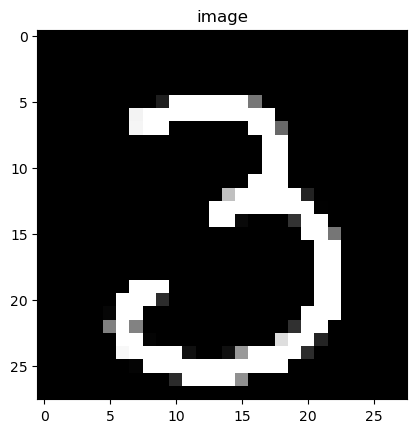

In [15]:
# Show demo image

import matplotlib.pyplot as plt
plt.imshow(img[0], cmap='gray')
plt.title('image')
plt.show()

In [18]:
# Prediction for demo image

classes = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
]

img_matrix_normalised = []
for array in img[0]:
    internal_array = []
    for number in array:
        updated_number = number / 256
        internal_array.append(updated_number)
    img_matrix_normalised.append(internal_array)

# add one more dimension to it
img_matrix_normalised = [img_matrix_normalised]

# make matrix into a pytorch tensor
img_tensor = torch.tensor(img_matrix_normalised, dtype=torch.float32)
print(img_tensor.shape)

model.eval()
with torch.no_grad():
    pred = model(img_tensor)

    # print all prediction probabilities
    print(pred)

    # print most probable prediction
    print(classes[pred[0].argmax(0)])

torch.Size([1, 28, 28])
tensor([[-0.1154,  0.0450,  0.4828,  0.5042, -0.2836, -0.1821, -0.1627, -0.1288,
          0.2115, -0.1450]])
3
